In [155]:
%matplotlib inline
from collections import defaultdict
import json

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression


rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['lines.linewidth'] = 2
rcParams['font.size'] = 14
rcParams['font.family'] = 'StixGeneral'

In [364]:
model_data = pd.read_csv("./D/data.csv")
model_data.tail(11)

,Date,DHR_Avg,LSD,Instrument,Industry,Dental,Environment,Water_Avg,OECD_6,PMI,...,water_avg,UR,FX1_SQ,ISM_M,EURO_CCI,Cap_Uti,DOLLAR,OECD_6_SQ,ESI_SQ,ISM_N
68,9 2013,0.024,0.05485,-0.01533,-0.01762,0.02813,0.07879,0.037,0.003346,51.4000,...,0.03733,-0.09556,0.003586,-0.00559,-15.9667,0.01472,0.00611,0.000011,0.012950,0.03356
69,10 2013,0.033,0.06525,-0.02233,0.00069,0.02428,0.05344,0.051,0.004016,51.8333,...,0.05133,-0.08462,0.004062,-0.00559,-15.0000,0.01538,0.00441,0.000016,0.022786,-0.00173
70,11 2013,0.052,0.05832,0.00500,0.03160,0.02339,0.05105,0.079,0.003680,52.3333,...,0.07933,-0.08159,0.004757,-0.00898,-14.9333,0.01441,0.00454,0.000014,0.026014,-0.01591
71,12 2013,0.037,0.03340,0.00233,0.03216,0.02129,0.00747,0.060,0.003345,52.7367,...,0.05967,-0.10658,0.004922,0.01159,-14.4667,0.01320,0.01254,0.000011,0.026270,-0.03054
72,1 2014,0.023,0.01768,-0.02900,0.02859,0.01411,0.03636,0.052,0.002674,53.0367,...,0.05233,-0.13927,0.003643,0.00346,-13.5333,0.01026,0.00120,0.000007,0.024056,-0.05186
73,2 2014,0.013,0.01294,-0.01400,0.00766,-0.01062,0.01698,0.036,0.002005,53.0700,...,0.03567,-0.15226,0.002424,0.04299,-12.6333,0.00865,-0.01184,0.000004,0.023744,-0.04140
74,3 2014,0.027,0.02858,-0.00433,0.02204,0.03303,0.02935,0.033,0.001336,52.8667,...,0.03267,-0.14162,0.001778,0.06273,-11.2333,0.00957,-0.03026,0.000002,0.022677,-0.02097
75,4 2014,0.028,0.03142,0.01167,0.03487,0.03732,0.03224,0.023,0.000668,52.5000,...,0.02300,-0.14469,0.002354,0.14156,-10.2000,0.01314,-0.03298,0.000000,0.026423,0.02136
76,5 2014,0.023,0.03504,0.00867,0.04946,0.03479,0.05985,0.022,0.000000,52.1333,...,0.02167,-0.15474,0.003266,0.14896,-8.3333,0.01601,-0.03555,0.000000,0.029392,0.05359
77,6 2014,0.023,0.04204,-0.01067,0.03576,0.00382,0.04885,0.041,-0.000667,52.2000,...,0.04067,-0.17696,0.004101,0.17706,-7.7333,0.01754,-0.02634,0.000000,0.029043,0.05648


In [157]:
variablelist_core = ["Water_Avg","PMI","OECD_6","TB","Econ"]
variablelist_LSD = ["OECD_6","PMI","SP500","ESI","fed_fund"]
variablelist_Instrument = ["OECD_6","FX1","water_avg","UR","FX1_SQ"]
variablelist_Industry = ["ISM_M","EURO_CCI","Cap_Uti","FX1"]
variablelist_Dental = ["OECD_6","Cap_Uti","ESI","DOLLAR","OECD_6_SQ","ESI_SQ"]
variablelist_Environment = ["ISM_M","fed_fund","OECD_6","ESI","ISM_N","DOLLAR"]
variable_list = [variablelist_core,variablelist_LSD,variablelist_Instrument,variablelist_Industry,variablelist_Dental,variablelist_Environment]
y_list = ["DHR_Avg","LSD","Instrument","Industry","Dental","Environment"]

In [281]:
lag = 6
reg = LinearRegression()
error = [[],[],[],[],[],[]] # 5 segments plus core model is 6 in total
forecast_error=[[],[],[],[],[],[]]
for i in range(6): # i = 0,1,2,3,4,5
    for t in range(64)[1:]: # t = 1,...,63,minimum training set=10
        x = model_data[variable_list[i]][:-lag-t]
        # when t=1,x has 72 data, when t=63,x has 10 data
        y = model_data[[y_list[i]]][lag:-t]
        x_test = model_data[variable_list[i]][-lag-t:-lag-t+1].values
        if t == 1:
            y_test = model_data[y_list[i]][-t:].values
        else: 
            y_test = model_data[y_list[i]][-t:-t+1].values
        reg.fit(x,y)
        predicted_y = reg.predict(x_test) 
        f = y_test - predicted_y #@t=1: N=72, y73-y73_hat, regression at 72D
        forecast_error[i].append(f)# remove the F73(N=72) after wards
        e = y.values[-1] - reg.predict(x.values[-1])#@t=1:N=72, y72-y72_hat, regression at 72D
        error[i].append(e)#e72(N=72)will not be used in regression but will only be used in forcast F73(N=72)
for i in range(6):
    error[i] = error[i][::-1] # e10...e72
    forecast_error[i] = forecast_error[i][::-1] # f11...f73

In [443]:
y=[[],[],[],[],[],[]]
y_hat=[[],[],[],[],[],[]]
y_predict=[[],[],[],[],[],[]]
y_EC=[[],[],[],[],[],[]]
r_square=[[],[],[],[],[],[]]
training_error=[[],[],[],[],[],[]]
test_error=[[],[],[],[],[],[]]
y_variable = [[],[],[],[],[],[]]
MSE_before = [0,0,0,0,0,0]
MSE_after = [0,0,0,0,0,0]
reg1 = LinearRegression()
reg2 = LinearRegression()
for i in range(6): # i = 0,1,2,3,4,5
    for t in range(59)[1:]: # t = 1,...,58,minimum training set=10
        p = len(variable_list[i])
        x = model_data[variable_list[i]][:-lag-t]
        # when t=1,x has 72 data, when t=58,x has 15 data
        y = model_data[y_list[i]][lag:-t]
        x_test = model_data[variable_list[i]][-lag-t:-lag-t+1].values
        if t == 1:
            y_test = model_data[y_list[i]][-t:].values
        else: 
            y_test = model_data[y_list[i]][-t:-t+1].values
        x_validation = model_data[variable_list[i]][-lag-t:-lag].values
        y_validation = model_data[[y_list[i]]][-t:].values
        reg1.fit(x,y)
        y_hat[i].append(reg1.predict(x.values[-1])) # 2 72...15
        y_predict[i].append(reg1.predict(x_test)) # 3 73...16
        rs = reg1.score(x,y)
        adjusted_rs = 1-(1-rs)*(len(x)-1)/(len(x)-p-1)
        r_square[i].append(adjusted_rs)
        y_training_fit = reg1.predict(x)
        y_test_fit = reg1.predict(x_validation)
        training_error[i].append(np.sqrt(np.mean((y-y_training_fit)**2)))
        test_error[i].append(np.sqrt(np.mean((y_validation-y_test_fit)**2)))
        error_regression = error[i][:-t]
        forecast_error_regression = forecast_error[i][:-t]
        reg2.fit(error_regression,forecast_error_regression)
        y_EC[i].append(reg1.predict(x_test)+reg2.predict(error[i][-t])) #4 73...16
    y_variable[i] = model_data[y_list[i]][20:] # 15...73
for i in range(6):
    y_hat[i] = y_hat[i][::-1] # 15...72
    y_predict[i] = y_predict[i][::-1] # 16...73
    y_EC[i] = y_EC[i][::-1] # 16...73
    r_square[i] = r_square[i][::-1] # 15...72
    training_error[i] = training_error[i][::-1] # training set size:15...72
    test_error[i] = test_error[i][::-1] # training set size:15...72
t = range(73)[15:]
for i in range(6):
    MSE_before[i] = np.sqrt(np.mean((np.array(y_variable[i][1:-1])-np.array(y_predict[i][0:-1]))**2)) # 16...72
    MSE_after[i] = np.sqrt(np.mean((np.array(y_variable[i][1:-1])-np.array(y_EC[i][0:-1])**2))) # 16...72

In [442]:
for i in range(6):
    MSE_before[i] = np.sqrt(np.mean((np.array(y_variable[i][1:-1])-np.array(y_predict[i][0:-1]))**2)) # 16...72
    MSE_after[i] = np.sqrt(np.mean((np.array(y_variable[i][1:-1])-np.array(y_EC[i][0:-1])**2))) # 16...72

In [444]:
MSE_before

[0.078953065365363492,
 0.052707884432646568,
 0.19136548631157999,
 0.13149591466333091,
 0.056315684474898063,
 0.065234547495712711]

In [445]:
MSE_after

[0.19371342779605394,
 0.20783911884372025,
 nan,
 0.1859692554780436,
 0.14870267996372491,
 0.20813179101665377]

In [434]:
len(y_variable[i][1:-1])

57

In [435]:
len(y_predict[i][0:-1])

57

In [438]:
a = [3,5,7]
b = [1,2,3]

#1 plot y vs. y_hat (15 ... 72)

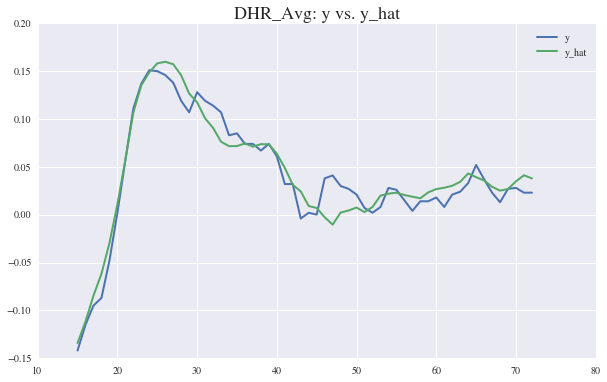

In [377]:
plt.plot(t,y_variable[0][:-1],label="y")
plt.plot(t,y_hat[0],label="y_hat")
plt.title("DHR_Avg: y vs. y_hat",size=18)
plt.legend()

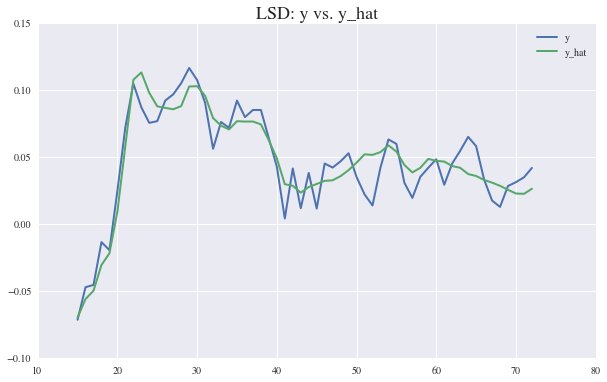

In [378]:
plt.plot(t,y_variable[1][:-1],label="y")
plt.plot(t,y_hat[1],label="y_hat")
plt.title("LSD: y vs. y_hat",size=18)
plt.legend()

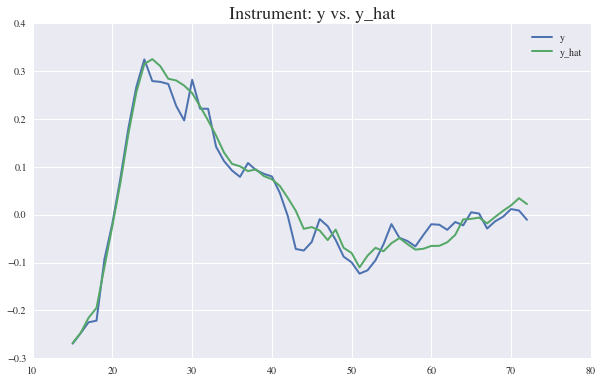

In [379]:
plt.plot(t,y_variable[2][:-1],label="y")
plt.plot(t,y_hat[2],label="y_hat")
plt.title("Instrument: y vs. y_hat",size=18)
plt.legend()

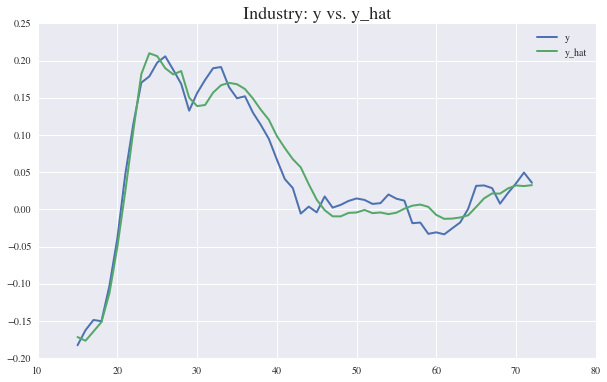

In [380]:
plt.plot(t,y_variable[3][:-1],label="y")
plt.plot(t,y_hat[3],label="y_hat")
plt.title("Industry: y vs. y_hat",size=18)
plt.legend()

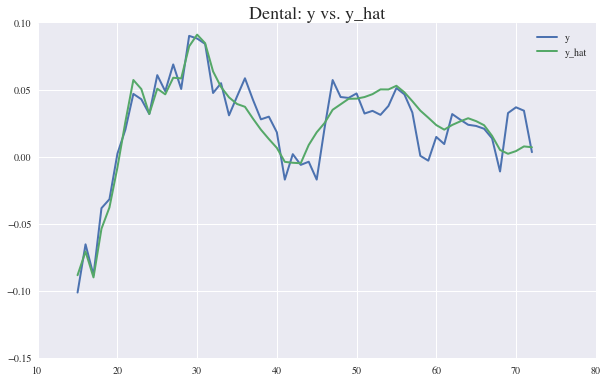

In [381]:
plt.plot(t,y_variable[4][:-1],label="y")
plt.plot(t,y_hat[4],label="y_hat")
plt.title("Dental: y vs. y_hat",size=18)
plt.legend()

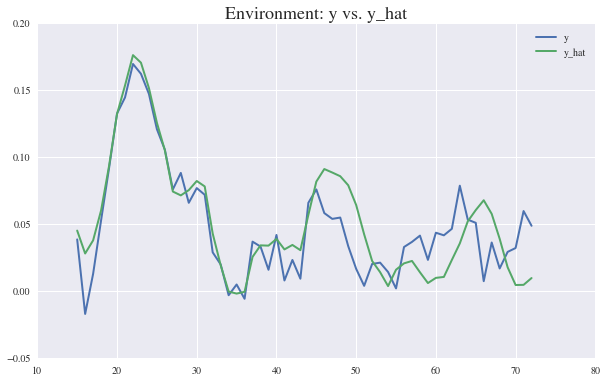

In [382]:
plt.plot(t,y_variable[5][:-1],label="y")
plt.plot(t,y_hat[5],label="y_hat")
plt.title("Environment: y vs. y_hat",size=18)
plt.legend()

#2 plot R^2 vs. training set size 15...72

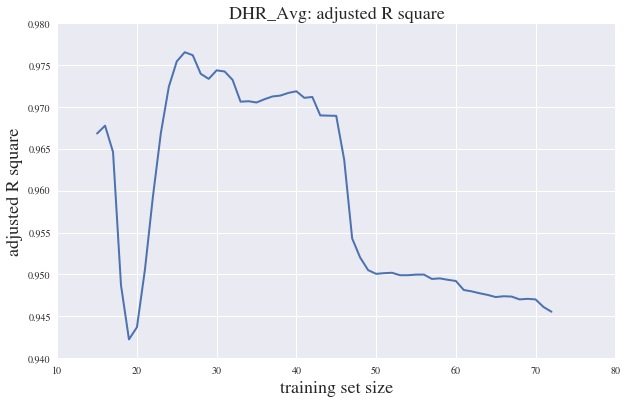

In [384]:
plt.plot(t,r_square[0])
plt.xlabel("training set size",size=18)
plt.ylabel("adjusted R square", size=18)
plt.title("DHR_Avg: adjusted R square",size=18)

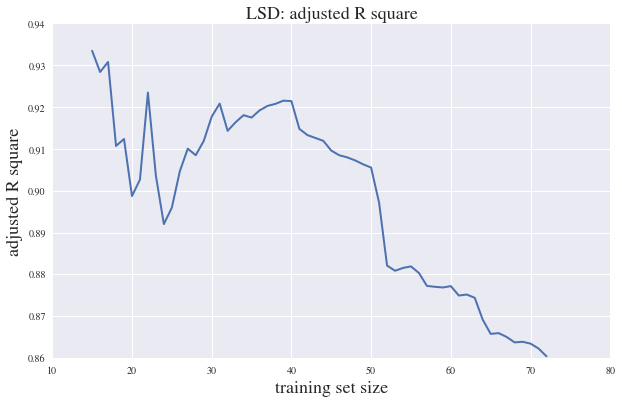

In [385]:
plt.plot(t,r_square[1])
plt.xlabel("training set size",size=18)
plt.ylabel("adjusted R square", size=18)
plt.title("LSD: adjusted R square",size=18)

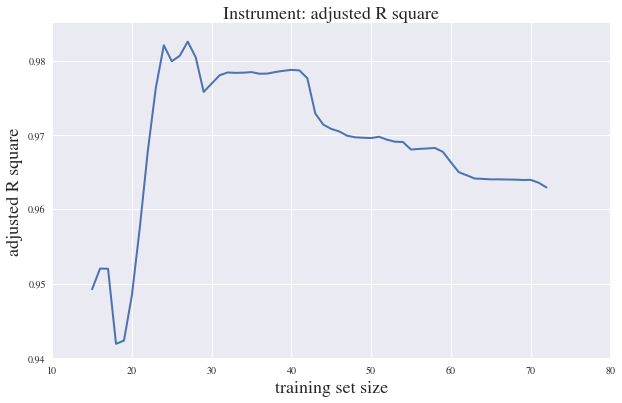

In [386]:
plt.plot(t,r_square[2])
plt.xlabel("training set size",size=18)
plt.ylabel("adjusted R square", size=18)
plt.title("Instrument: adjusted R square",size=18)

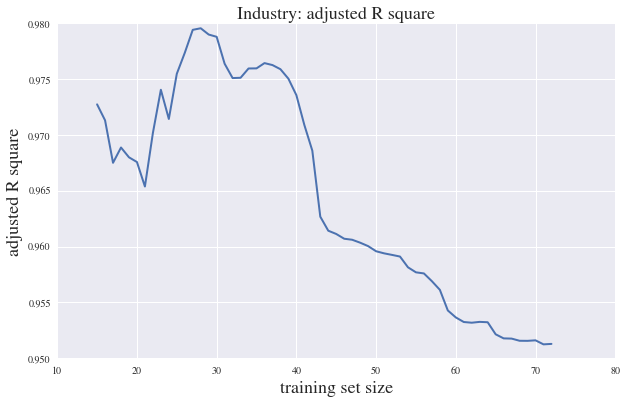

In [387]:
plt.plot(t,r_square[3])
plt.xlabel("training set size",size=18)
plt.ylabel("adjusted R square", size=18)
plt.title("Industry: adjusted R square",size=18)

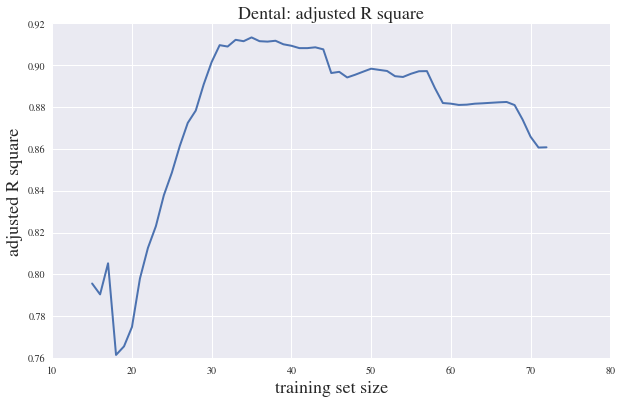

In [388]:
plt.plot(t,r_square[4])
plt.xlabel("training set size",size=18)
plt.ylabel("adjusted R square", size=18)
plt.title("Dental: adjusted R square",size=18)

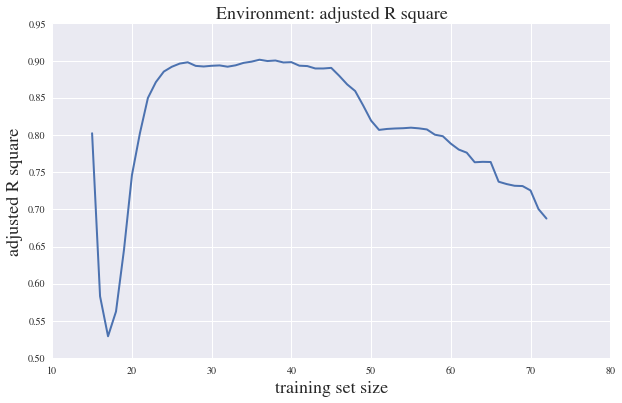

In [389]:
plt.plot(t,r_square[5])
plt.xlabel("training set size",size=18)
plt.ylabel("adjusted R square", size=18)
plt.title("Environment: adjusted R square",size=18)

#3 plot errors vs. training set size 

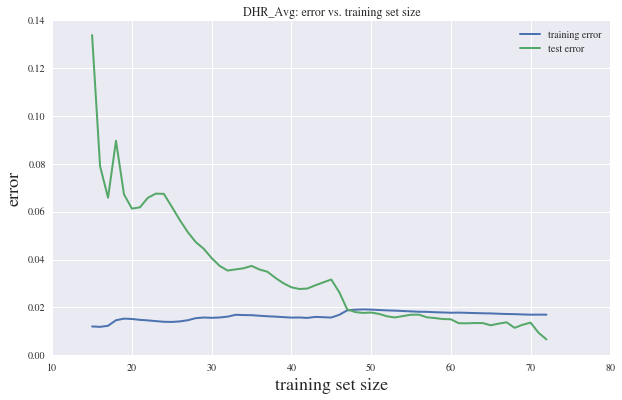

In [391]:
plt.plot(t,training_error[0],label='training error')
plt.plot(t,test_error[0],label='test error')
plt.xlabel("training set size",size=18)
plt.ylabel("error",size=18)
plt.title("DHR_Avg: error vs. training set size")
plt.legend()

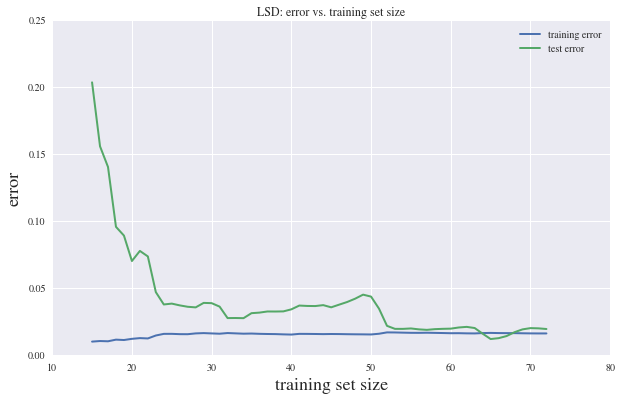

In [392]:
plt.plot(t,training_error[1],label='training error')
plt.plot(t,test_error[1],label='test error')
plt.xlabel("training set size",size=18)
plt.ylabel("error",size=18)
plt.title("LSD: error vs. training set size")
plt.legend()

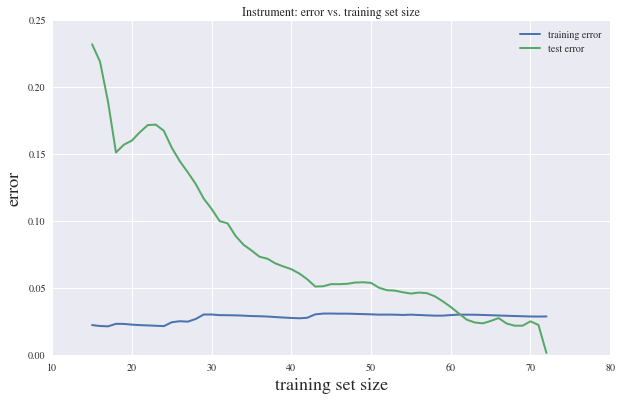

In [393]:
plt.plot(t,training_error[2],label='training error')
plt.plot(t,test_error[2],label='test error')
plt.xlabel("training set size",size=18)
plt.ylabel("error",size=18)
plt.title("Instrument: error vs. training set size")
plt.legend()

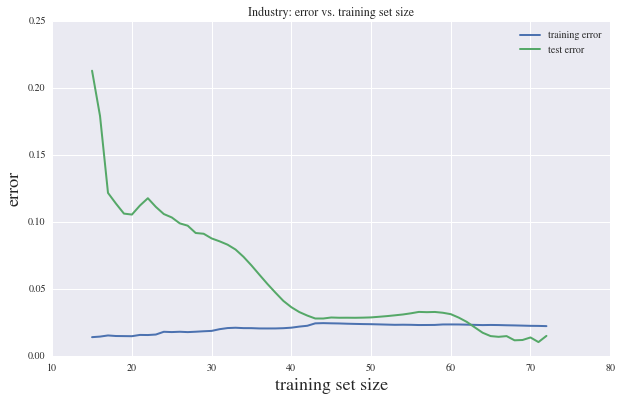

In [394]:
plt.plot(t,training_error[3],label='training error')
plt.plot(t,test_error[3],label='test error')
plt.xlabel("training set size",size=18)
plt.ylabel("error",size=18)
plt.title("Industry: error vs. training set size")
plt.legend()

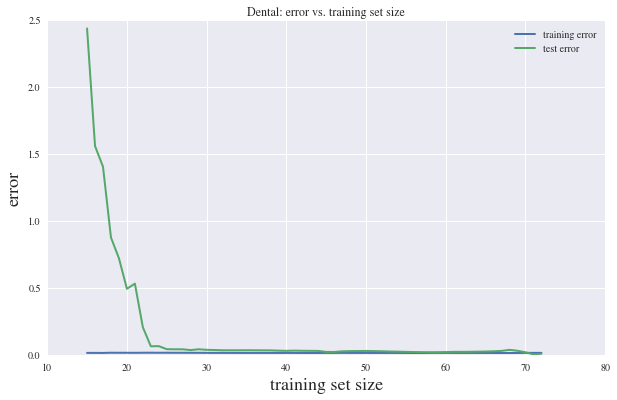

In [395]:
plt.plot(t,training_error[4],label='training error')
plt.plot(t,test_error[4],label='test error')
plt.xlabel("training set size",size=18)
plt.ylabel("error",size=18)
plt.title("Dental: error vs. training set size")
plt.legend()

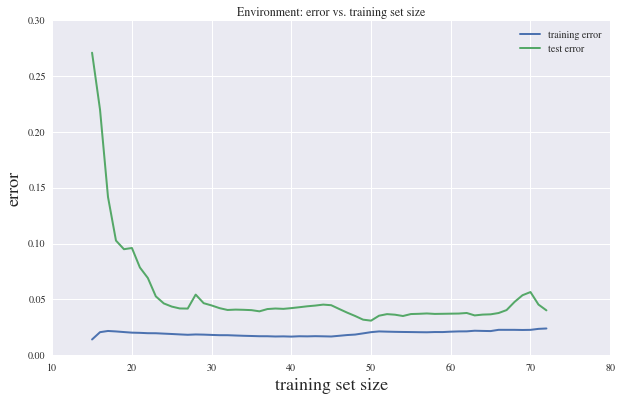

In [396]:
plt.plot(t,training_error[5],label='training error')
plt.plot(t,test_error[5],label='test error')
plt.xlabel("training set size",size=18)
plt.ylabel("error",size=18)
plt.title("Environment: error vs. training set size")
plt.legend()